# GAT

Velickovic et al. (2017) introduced a novel neural network architecture, known as the graph attention network (GAT), for processing graph-structured data. GATs overcome the limitations of previous graph convolution-based methods by utilizing masked self-attentional layers. Through layer stacking, nodes are empowered to attend to the features of their neighborhoods, allowing for the implicit assignment of varying weights to different nodes without the need for expensive matrix operations or prior knowledge of the graph structure. Given an input graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ and a set of node features $\textbf{X} \in \mathbb{R}^{d \times |\mathcal{V}|}$, Velickovic et al. (2017) describe their graph attention mechanism as follows.

$$
\alpha_{un} = \frac{
\text{exp} \left( \text{LeakyReLu} \left( \vec{\textbf{a}}^\textbf{T} \left[ \textbf{W}_u || \textbf{W}_n \right] \right) \right)
}{
\sum_{v\in \mathcal{N}(u)} \text{exp} \left( \text{LeakyReLu} \left( \vec{\textbf{a}}^\textbf{T} \left[ \textbf{W}_u || \textbf{W}_v \right] \right) \right) }
$$

where

- for each node $u \in \mathcal{V}$, $v \in \mathcal{N}(u)$ and $\mathcal{N}(u)$ is the set of neighbourhood nodes of $u$
- $\alpha_{un}$ is the attention coefficient that indicates the importance of node $n$'s features to node $u$
- LeakyReLu is the activation function
- $.^T$ represents transposition
- $||$ is the concatenation operator
- $\vec{\textbf{a}}$ is a weight vector that parameterise the attention mechanism $a$, where $a$ can be a neural network

The graph structure is injected into the mechanism by performing *masked attention*, which computes $a ( \textbf{W}_u, \textbf{W}_v )$ for nodes $v \in \mathcal{N}(u) $. The normalized attention coefficients are employed to compute a linear combination of the corresponding features, thereby producing the final output features for each node. To enhance the learning process of self-attention, a multi-head attention mechanism is utilized.

$$
u' = \text{\LARGE $||$}^M_{m=1} \sigma \left( \sum_{v \in \mathcal{N}(u)} \alpha_{uv}^{(m)} \textbf{W}^{(m)}_v \right)
$$

where

- $\sigma$ is the potential nonlinearity
- $M$ is the number of independent attention mechanisms to execute
- $\alpha_{uv}^{(m)}$ are normalized attention coefficients computed by the $m^{\text{th}}$ attention mechanism $a^{(m)}$ and $W^{(m)}$ is the corresponding input linear transformation's weight matrix.

In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
from model.dgl.GAT import GAT
from sklearn.metrics import mean_squared_error, r2_score
from data.featurization.dgl_Graph import DGL_Graph
from model.dgl.DGLModel import DGLModel
from model.abstractmodel import AbstractModel
from ray import tune
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST1 = Dataset.load_csv("ds/TST_1")
TST2 = Dataset.load_csv("ds/TST_2")

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST1.X = TST1.featurize(featurizer)
TST2.X = TST2.featurize(featurizer)

In [5]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [5]:
RANDOM_STATE = 1234
SPACE = {
    "hidden_feats": tune.choice([[64], [64, 64], [64, 64, 64], [64, 128], [64, 128, 256]]),
    "num_heads": tune.randint(2, 6),
    "feat_drops": tune.uniform(0, 1),
    "attn_drops": tune.uniform(0, 1),
    "alphas": tune.uniform(0, 1),
    "residuals": tune.choice([True, False]),
    "agg_modes": tune.choice(["flatten", "mean"]),
    "biases": tune.choice([True, False]),
    "lr": tune.choice([0.1, 0.01, 0.001]),
    "weight_decay": tune.uniform(0, 1),
    "epoch": tune.choice([100, 150, 200, 250, 300]),
}

In [6]:
def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    model = GAT(
        task_type="regression",
        # GAT Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=config["hidden_feats"],
        num_heads=config["num_heads"],
        feat_drops=config["feat_drops"],
        attn_drops=config["attn_drops"],
        alphas=config["alphas"],
        residuals=config["residuals"],
        agg_modes=config["agg_modes"],
        biases=config["biases"],
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=config["lr"],
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=4096,
        verbose=False
    )
    scores = model.fit(trn, val=val, epochs=config["epoch"], verbose=False)
    tune.report(rmse=scores["rmse"][-1])

In [7]:
from ray.tune.search import BasicVariantGenerator

tuner = DGLModel.tuner(
    trainable_func,
    SPACE,
    num_samples=50,
    search_alg=BasicVariantGenerator(max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-14 13:10:37,453	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_9a153_00000,2023-03-14_13-11-11,False,,fa270f4fec6640e4982001bc0faf6e04,64-4090-13700K,1,127.0.0.1,37236,2.273,28.0222,28.0222,28.0222,1678799471,0,,1,9a153_00000,0.00299954


2023-03-14 14:05:51,270	INFO tune.py:798 -- Total run time: 3310.45 seconds (3310.35 seconds for the tuning loop).


In [8]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'hidden_feats': [64],
 'num_heads': 5,
 'feat_drops': 0.2023595030995624,
 'attn_drops': 0.26105451494398646,
 'alphas': 0.5288055588532301,
 'residuals': True,
 'agg_modes': 'flatten',
 'biases': True,
 'lr': 0.001,
 'weight_decay': 0.022066762838043652,
 'epoch': 250}

In [5]:
MODEL = GAT(
    task_type="regression",
    # GAT Configuration
    n_tasks=1,
    in_feats=featurizer.get_node_feat_size(),
    hidden_feats=[64],
    num_heads=5,
    feat_drops=0.2023595030995624,
    attn_drops=0.26105451494398646,
    alphas=0.5288055588532301,
    residuals=True,
    agg_modes="flatten",
    biases=True,
    classifier_hidden_feats=128,
    classifier_dropout=0,
    predictor_hidden_feats=128,
    predictor_dropout=0,
    # Abstract DGL Configuration
    lr=0.001,
    y_name="LogS exp (mol/L)",
    weight_decay=0,
    batch_size=4096
)
trn, val = TRN.split()
scores = MODEL.fit(trn, val=val, epochs=250)

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


100%|██████████| 250/250 [01:18<00:00,  3.18it/s, loss: 0.878 rmse: 1.198]


<AxesSubplot: >

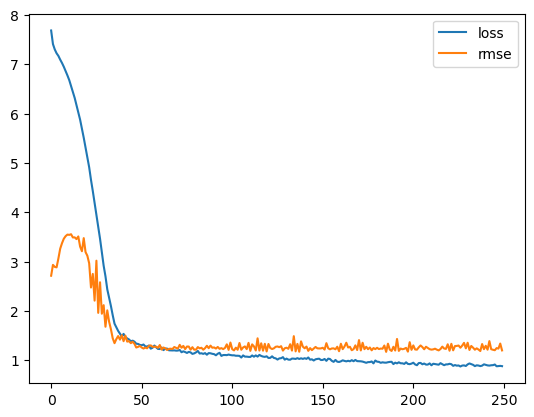

In [6]:
pd.DataFrame({
    "loss": [v.item() for v in MODEL.scores["loss"]],
    "rmse": [v.item() for v in MODEL.scores["rmse"]]
}).plot()

In [7]:
result = MODEL.cross_validate(
    dataset=TRN,
    epochs=250,
    extra_eval_set=TST1,
    cv=5,
    verbose=True
)

[CV 4]: 100%|██████████| 250/250 [01:14<00:00,  3.36it/s, loss: 1.233, val_rmse: 1.127]


In [10]:
np.std(result["rmse"]), np.mean(result["rmse"])

(1.0250312, 1.5049723)

In [11]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, MODEL.predict(TST1).cpu(), squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, MODEL.predict(TST2).cpu(), squared=False)}")

TST1 : RMSE 1.0110822959921273
TST2 : RMSE 2.056503992488948


In [6]:
SPACE = {
    "num_heads": tune.uniform(4, 8),
    "feat_drops": tune.uniform(0, 0.4),
    "attn_drops": tune.uniform(0, 0.4),
    "alphas": tune.uniform(0, 1),
    "weight_decay": tune.uniform(0, 1),
    "epoch": tune.uniform(200, 400),
}

In [7]:
def trainable_func(config: dict, dataset: Dataset):
    trn, val = dataset.split()
    model = GAT(
        task_type="regression",
        # GAT Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 64],
        num_heads=int(config["num_heads"]),
        feat_drops=config["feat_drops"],
        attn_drops=config["attn_drops"],
        alphas=config["alphas"],
        residuals=True,
        agg_modes="flatten",
        biases=True,
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=4096,
        verbose=False
    )
    scores = model.fit(trn, val=val, epochs=int(config["epoch"]), verbose=False)
    tune.report(rmse=scores["rmse"][-1])

In [8]:
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search import ConcurrencyLimiter

tuner = DGLModel.tuner(
    trainable_func,
    space=SPACE,
    num_samples=50,
    search_alg=ConcurrencyLimiter(BayesOptSearch(metric="rmse", mode="min"), max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-14 17:27:31,852	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_8cf40aef,2023-03-14_17-30-05,False,,69c068a309fe4d24a26e0c31f942e100,64-4090-13700K,1,127.0.0.1,24920,1.52187,146.872,146.872,146.872,1678815005,0,,1,8cf40aef,0.00200129


2023-03-14 18:48:01,077	INFO tune.py:798 -- Total run time: 4825.75 seconds (4825.65 seconds for the tuning loop).


In [9]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'num_heads': 5.728851734733783,
 'feat_drops': 0.0,
 'attn_drops': 0.0,
 'alphas': 0.0,
 'weight_decay': 0.0,
 'epoch': 349.82262756404924}

In [11]:
num_heads = 5
AbstractModel.set_seed(2387)

k_pred_tst1 = []
k_pred_tst2 = []

for trn, val in zip(trn_sets, val_sets):
    model = GAT(
        task_type="regression",
        # GAT Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 64 * num_heads],
        num_heads=num_heads,
        feat_drops=0,
        attn_drops=0,
        alphas=0,
        residuals=True,
        agg_modes="flatten",
        biases=True,
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0,
        batch_size=4096,
    )
    model.fit(trn, val=val, epochs=400, min_epoch=195, early_stop=20)

    k_pred_tst1.append(model.predict(TST1).cpu())
    k_pred_tst2.append(model.predict(TST2).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 62%|██████▎   | 250/400 [01:34<00:56,  2.65it/s, loss: 0.534 rmse: 1.271]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 56%|█████▌    | 223/400 [01:23<01:06,  2.68it/s, loss: 0.408 rmse: 1.856]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 56%|█████▌    | 223/400 [01:25<01:07,  2.61it/s, loss: 0.425 rmse: 1.338]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 54%|█████▍    | 216/400 [01:23<01:11,  2.58it/s, loss: 0.570 rmse: 0.954]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 54%|█████▍    | 216/400 [01:23<01:10,  2.60it/s, loss: 0.535 rmse: 1.184]


In [ ]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]
pred_tst2 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst2, 1)]

In [13]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, pred_tst1, squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, pred_tst2, squared=False)}")

TST1 : RMSE 0.6541950652927421
TST2 : RMSE 1.379693717714225


In [16]:
print(f"TST1 : R^2 {r2_score(TST1.y, pred_tst1)}")
print(f"TST2 : R^2 {r2_score(TST2.y, pred_tst2)}")

TST1 : R^2 0.7329273975878594
TST2 : R^2 0.5850074198064612


Text(0.5, 1.0, '2019 Solubility Challenge Test Set 2 (GAT)\nRMSE: 1.380, $R^2$: 0.585')

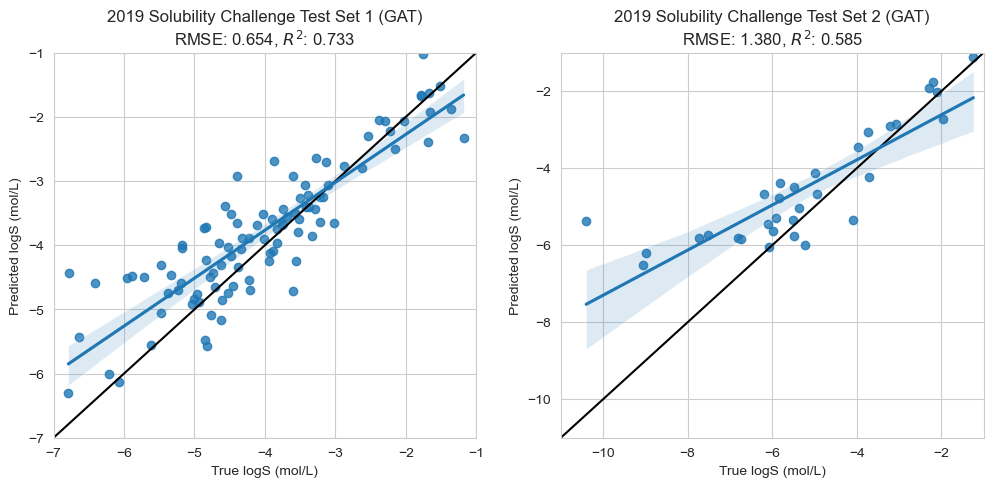

In [18]:
model_name = "GAT"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -11, -1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST1.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST2.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst2
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax2
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)

ax1.set_title(f"2019 Solubility Challenge Test Set 1 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST1.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST1.y, pred_tst1):.3f}")
ax2.set_title(f"2019 Solubility Challenge Test Set 2 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST2.y, pred_tst2, squared=False):.3f}, $R^2$: {r2_score(TST2.y, pred_tst2):.3f}")

# plt.axis("equal")

Try a smaller dataset

In [7]:
TRN = Dataset.load_csv("ds/exclude_CSD/TRN_DC")
TST1 = Dataset.load_csv("ds/all/TST_1")
TST2 = Dataset.load_csv("ds/all/TST_2")

In [8]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST1.X = TST1.featurize(featurizer)
TST2.X = TST2.featurize(featurizer)

In [9]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [13]:
num_heads = 5
AbstractModel.set_seed(2387)

k_pred_tst1 = []
k_pred_tst2 = []

for trn, val in zip(trn_sets, val_sets):
    model = GAT(
        task_type="regression",
        # GAT Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 64 * num_heads],
        num_heads=num_heads,
        feat_drops=0,
        attn_drops=0,
        alphas=0,
        residuals=True,
        agg_modes="flatten",
        biases=True,
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0,
        batch_size=4096,
    )
    model.fit(trn, val=val, epochs=400, min_epoch=200, early_stop=20)

    k_pred_tst1.append(model.predict(TST1).cpu())
    k_pred_tst2.append(model.predict(TST2).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 57%|█████▊    | 230/400 [00:14<00:11, 15.35it/s, loss: 0.011 rmse: 1.102]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 63%|██████▎   | 252/400 [00:17<00:10, 14.60it/s, loss: 0.008 rmse: 0.576] 


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 55%|█████▌    | 221/400 [00:14<00:12, 14.86it/s, loss: 0.011 rmse: 0.725]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 56%|█████▌    | 224/400 [00:15<00:11, 14.88it/s, loss: 0.011 rmse: 0.928]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 59%|█████▉    | 236/400 [00:15<00:11, 14.87it/s, loss: 0.019 rmse: 0.720] 


In [14]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]
pred_tst2 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst2, 1)]

In [15]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, pred_tst1, squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, pred_tst2, squared=False)}")
print(f"TST1 : R^2 {r2_score(TST1.y, pred_tst1)}")
print(f"TST2 : R^2 {r2_score(TST2.y, pred_tst2)}")

TST1 : RMSE 0.843630206439343
TST2 : RMSE 1.2310581211722678
TST1 : R^2 0.5558608537573719
TST2 : R^2 0.6696060597956218
